In [647]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from xgboost.callback import EarlyStopping

In [648]:
# Adjust settings to prevent wrapping or truncated displays
pd.set_option('display.max_colwidth', None)  # Ensures no truncation of column contents
pd.set_option('display.max_columns', None)  # Ensures all columns are shown
pd.set_option('display.max_rows', None)  # Ensures no truncation for rows
pd.set_option('display.expand_frame_repr', False)  # Prevents line wrapping for DataFrame

In [649]:
df = pd.read_csv('final_combined_dataset.csv')

df.head(5)

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geocode,vim,vim_monthly,precipitation_avg_ordinary_kriging,precipitation_max_ordinary_kriging,precipitation_avg_regression_kriging,precipitation_max_regression_kriging,long,lat,cases_per_100k,nearby_cases_weighted
0,2012-01-01,201201,32,207044,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,angra dos reis,3300100,0.850500,0.852633,5.6804,18.3375,5.2038,18.7979,-44.319627,-23.009116,15.455652,6.913995
1,2012-01-08,201202,40,207044,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,angra dos reis,3300100,0.852050,0.852633,4.0716,16.5375,3.9114,16.8583,-44.319627,-23.009116,19.319565,32.825012
2,2012-01-15,201203,19,207044,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,angra dos reis,3300100,0.853541,0.852633,2.0555,5.0500,1.7556,3.1368,-44.319627,-23.009116,9.176793,14.685214
3,2012-01-22,201204,33,207044,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,angra dos reis,3300100,0.854877,0.852633,1.5416,5.7059,1.4138,5.2767,-44.319627,-23.009116,15.938641,2.809255
4,2012-01-29,201205,36,207044,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,angra dos reis,3300100,0.856021,0.852633,2.8204,9.3826,2.0057,7.8749,-44.319627,-23.009116,17.387608,19.938997


In [650]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52234 entries, 0 to 52233
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  52234 non-null  object 
 1   week                                  52234 non-null  int64  
 2   cases                                 52234 non-null  int64  
 3   population                            52234 non-null  int64  
 4   tempe_min                             52234 non-null  float64
 5   humidity_max                          52234 non-null  float64
 6   humidity_avg                          52234 non-null  float64
 7   humidity_min                          52234 non-null  float64
 8   temp_avg                              52234 non-null  float64
 9   temp_max                              52234 non-null  float64
 10  city                                  52234 non-null  object 
 11  geocode        

In [651]:
# Shift the cases column to create the 2-weeks-ahead target
df['cases_2w_ahead'] = df.groupby('geocode')['cases'].shift(-2)

# Drop the last 2 rows for each municipality (since they won't have a future target)
df = df.dropna(subset=['cases_2w_ahead']).reset_index(drop=True)

df.head(10)

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geocode,vim,vim_monthly,precipitation_avg_ordinary_kriging,precipitation_max_ordinary_kriging,precipitation_avg_regression_kriging,precipitation_max_regression_kriging,long,lat,cases_per_100k,nearby_cases_weighted,cases_2w_ahead
0,2012-01-01,201201,32,207044,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,angra dos reis,3300100,0.850500,0.852633,5.6804,18.3375,5.2038,18.7979,-44.319627,-23.009116,15.455652,6.913995,19.0
1,2012-01-08,201202,40,207044,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,angra dos reis,3300100,0.852050,0.852633,4.0716,16.5375,3.9114,16.8583,-44.319627,-23.009116,19.319565,32.825012,33.0
2,2012-01-15,201203,19,207044,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,angra dos reis,3300100,0.853541,0.852633,2.0555,5.0500,1.7556,3.1368,-44.319627,-23.009116,9.176793,14.685214,36.0
3,2012-01-22,201204,33,207044,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,angra dos reis,3300100,0.854877,0.852633,1.5416,5.7059,1.4138,5.2767,-44.319627,-23.009116,15.938641,2.809255,39.0
4,2012-01-29,201205,36,207044,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,angra dos reis,3300100,0.856021,0.852633,2.8204,9.3826,2.0057,7.8749,-44.319627,-23.009116,17.387608,19.938997,37.0
5,2012-02-05,201206,39,207044,19.571429,81.571429,43.494048,22.142857,28.614927,33.571429,angra dos reis,3300100,0.857159,0.858000,3.8170,25.9830,3.8228,26.0478,-44.319627,-23.009116,18.836576,8.766989,33.0
6,2012-02-12,201207,37,207044,20.142857,80.142857,56.778911,40.571429,25.791314,29.571429,angra dos reis,3300100,0.858241,0.858000,4.0861,29.4086,4.0920,29.0110,-44.319627,-23.009116,17.870598,12.823065,46.0
7,2012-02-19,201208,33,207044,21.857143,74.000000,51.458425,34.428571,27.253296,31.285714,angra dos reis,3300100,0.859142,0.858000,0.5962,4.0133,0.4783,3.2643,-44.319627,-23.009116,15.938641,12.077424,42.0
8,2012-02-26,201209,46,207044,20.714286,80.142857,43.760989,21.285714,28.902930,34.000000,angra dos reis,3300100,0.860082,0.858000,0.8143,3.8456,0.8171,3.8703,-44.319627,-23.009116,22.217500,6.661086,38.0
9,2012-03-04,201210,42,207044,20.428571,71.714286,48.333639,28.428571,26.467491,30.857143,angra dos reis,3300100,0.860933,0.861567,1.1867,5.3867,0.6647,3.8741,-44.319627,-23.009116,20.285543,3.513488,52.0


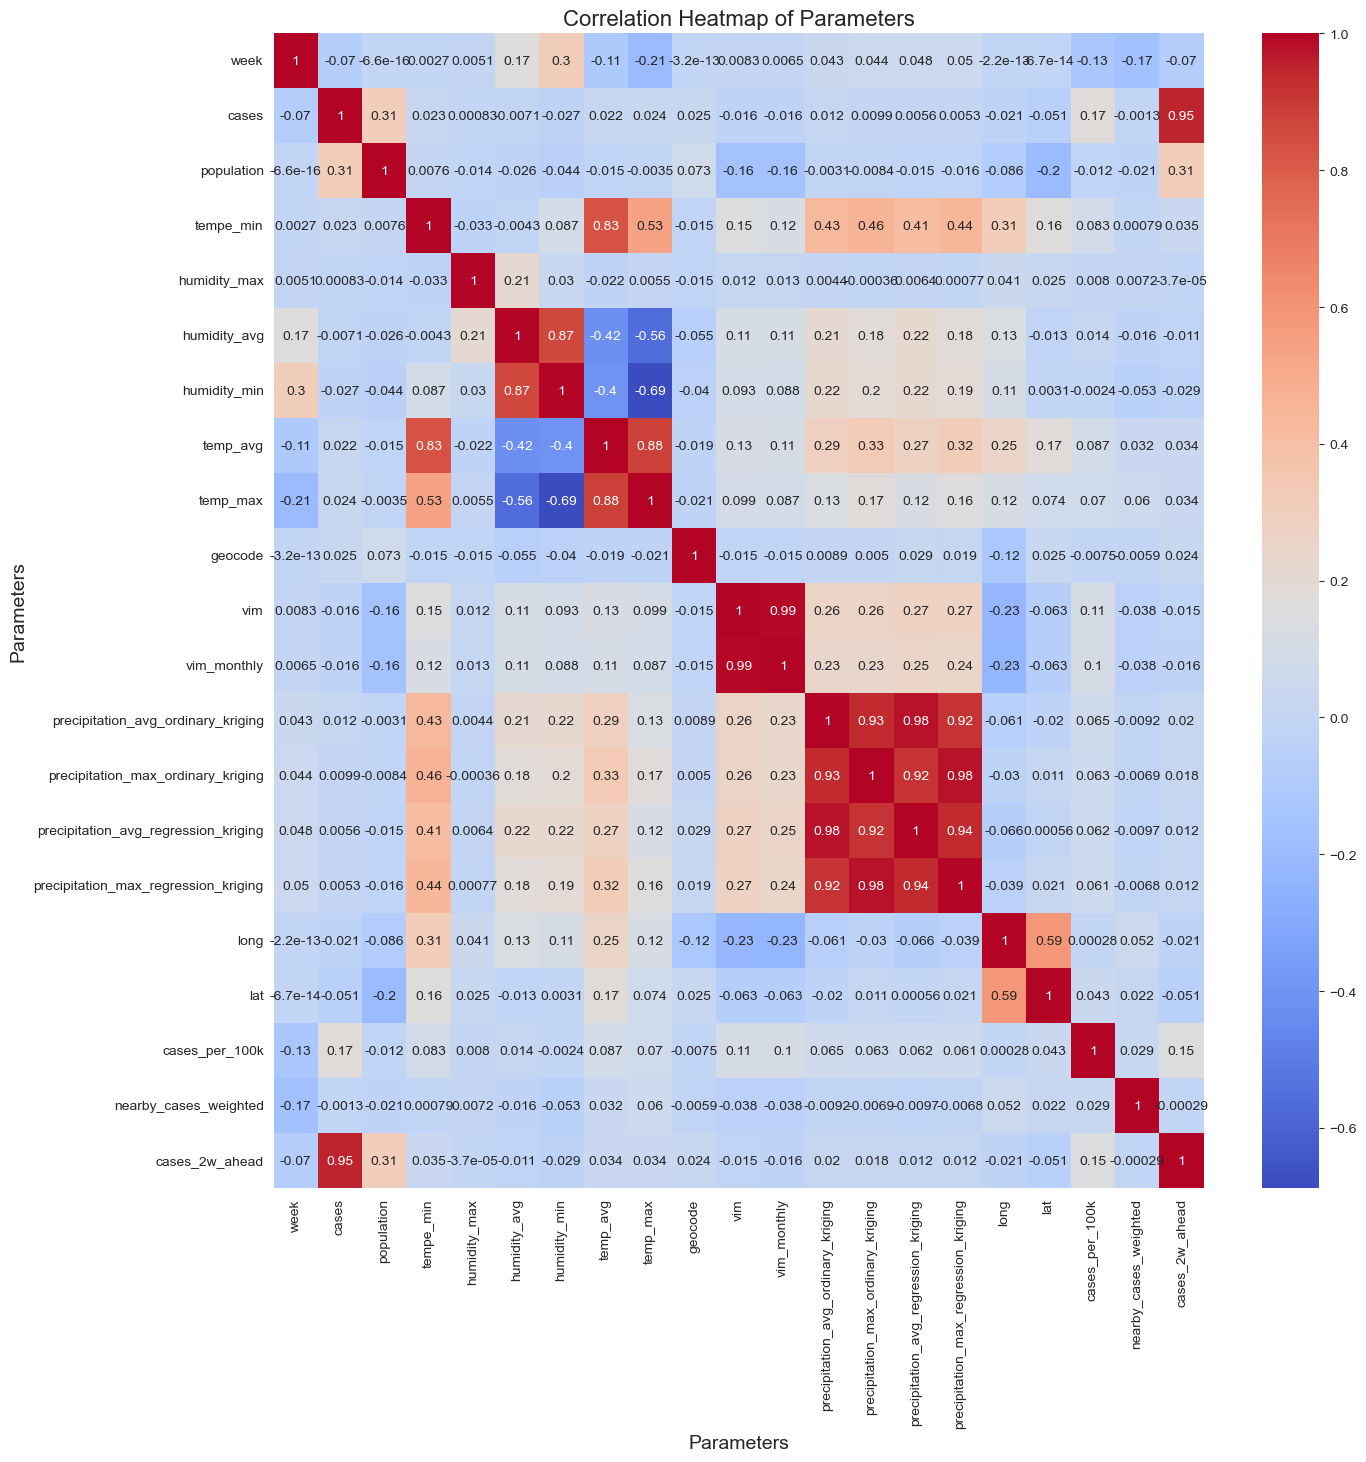

In [652]:
# Calculate the correlation matrix
s = df.select_dtypes(include="number").corr()

# Create the heatmap
plt.figure(figsize=(15, 15))
heatmap = sns.heatmap(s, annot=True, cmap="coolwarm")

plt.xlabel("Parameters", fontsize=14)
plt.ylabel("Parameters", fontsize=14)
plt.title("Correlation Heatmap of Parameters", fontsize=16)

plt.show()

In [653]:
# Ensure 'week' is numeric to allow mathematical operations; invalid values become NaN
df['week'] = pd.to_numeric(df['week'], errors='coerce')

# Convert 'date' to datetime format for easier manipulation and analysis
df['date'] = pd.to_datetime(df['date'])

# Add ordinal date
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# Extract year/month features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Extract the week number (last two digits of 'week')
df['week_num'] = df['week'] % 100

# Add cyclic representations for month and week
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['week_sin'] = np.sin(2 * np.pi * df['week_num'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week_num'] / 52)

# Drop the original 'date' and redundant 'month' and 'week_num' columns
df = df.drop(columns=['date', 'month', 'week_num'])
df.head(5)

,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geocode,vim,vim_monthly,precipitation_avg_ordinary_kriging,precipitation_max_ordinary_kriging,precipitation_avg_regression_kriging,precipitation_max_regression_kriging,long,lat,cases_per_100k,nearby_cases_weighted,cases_2w_ahead,date_ordinal,year,month_sin,month_cos,week_sin,week_cos
0,201201,32,207044,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,angra dos reis,3300100,0.850500,0.852633,5.6804,18.3375,5.2038,18.7979,-44.319627,-23.009116,15.455652,6.913995,19.0,734503,2012,0.5,0.866025,0.120537,0.992709
1,201202,40,207044,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,angra dos reis,3300100,0.852050,0.852633,4.0716,16.5375,3.9114,16.8583,-44.319627,-23.009116,19.319565,32.825012,33.0,734510,2012,0.5,0.866025,0.239316,0.970942
2,201203,19,207044,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,angra dos reis,3300100,0.853541,0.852633,2.0555,5.0500,1.7556,3.1368,-44.319627,-23.009116,9.176793,14.685214,36.0,734517,2012,0.5,0.866025,0.354605,0.935016
3,201204,33,207044,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,angra dos reis,3300100,0.854877,0.852633,1.5416,5.7059,1.4138,5.2767,-44.319627,-23.009116,15.938641,2.809255,39.0,734524,2012,0.5,0.866025,0.464723,0.885456
4,201205,36,207044,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,angra dos reis,3300100,0.856021,0.852633,2.8204,9.3826,2.0057,7.8749,-44.319627,-23.009116,17.387608,19.938997,37.0,734531,2012,0.5,0.866025,0.568065,0.822984


In [654]:
# Add lag features to capture the relationship between current and past cases
df['cases_lag0'] = df.groupby('geocode')['cases'].shift(0)
df['cases_lag1'] = df.groupby('geocode')['cases'].shift(1)

df['precipitation_avg_ordinary_kriging_lag3'] = df.groupby('geocode')['precipitation_avg_ordinary_kriging'].shift(3)
df['precipitation_avg_ordinary_kriging_lag4'] = df.groupby('geocode')['precipitation_avg_ordinary_kriging'].shift(4)

df.head(5)

,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geocode,vim,vim_monthly,precipitation_avg_ordinary_kriging,precipitation_max_ordinary_kriging,precipitation_avg_regression_kriging,precipitation_max_regression_kriging,long,lat,cases_per_100k,nearby_cases_weighted,cases_2w_ahead,date_ordinal,year,month_sin,month_cos,week_sin,week_cos,cases_lag0,cases_lag1,precipitation_avg_ordinary_kriging_lag3,precipitation_avg_ordinary_kriging_lag4
0,201201,32,207044,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,angra dos reis,3300100,0.850500,0.852633,5.6804,18.3375,5.2038,18.7979,-44.319627,-23.009116,15.455652,6.913995,19.0,734503,2012,0.5,0.866025,0.120537,0.992709,32,NaN,NaN,NaN
1,201202,40,207044,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,angra dos reis,3300100,0.852050,0.852633,4.0716,16.5375,3.9114,16.8583,-44.319627,-23.009116,19.319565,32.825012,33.0,734510,2012,0.5,0.866025,0.239316,0.970942,40,32.0,NaN,NaN
2,201203,19,207044,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,angra dos reis,3300100,0.853541,0.852633,2.0555,5.0500,1.7556,3.1368,-44.319627,-23.009116,9.176793,14.685214,36.0,734517,2012,0.5,0.866025,0.354605,0.935016,19,40.0,NaN,NaN
3,201204,33,207044,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,angra dos reis,3300100,0.854877,0.852633,1.5416,5.7059,1.4138,5.2767,-44.319627,-23.009116,15.938641,2.809255,39.0,734524,2012,0.5,0.866025,0.464723,0.885456,33,19.0,5.6804,NaN
4,201205,36,207044,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,angra dos reis,3300100,0.856021,0.852633,2.8204,9.3826,2.0057,7.8749,-44.319627,-23.009116,17.387608,19.938997,37.0,734531,2012,0.5,0.866025,0.568065,0.822984,36,33.0,4.0716,5.6804


In [655]:
# Drop the first 4 rows from each 'geocode' group (due to NaNs in lag features)
df = (
    df.groupby('geocode', group_keys=False)
      .apply(lambda group: group.iloc[4:])
      .reset_index(drop=True)
)

df.head(5)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15732\82962463.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.iloc[4:])


,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geocode,vim,vim_monthly,precipitation_avg_ordinary_kriging,precipitation_max_ordinary_kriging,precipitation_avg_regression_kriging,precipitation_max_regression_kriging,long,lat,cases_per_100k,nearby_cases_weighted,cases_2w_ahead,date_ordinal,year,month_sin,month_cos,week_sin,week_cos,cases_lag0,cases_lag1,precipitation_avg_ordinary_kriging_lag3,precipitation_avg_ordinary_kriging_lag4
0,201205,36,207044,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,angra dos reis,3300100,0.856021,0.852633,2.8204,9.3826,2.0057,7.8749,-44.319627,-23.009116,17.387608,19.938997,37.0,734531,2012,0.500000,0.866025,0.568065,0.822984,36,33.0,4.0716,5.6804
1,201206,39,207044,19.571429,81.571429,43.494048,22.142857,28.614927,33.571429,angra dos reis,3300100,0.857159,0.858000,3.8170,25.9830,3.8228,26.0478,-44.319627,-23.009116,18.836576,8.766989,33.0,734538,2012,0.866025,0.500000,0.663123,0.748511,39,36.0,2.0555,4.0716
2,201207,37,207044,20.142857,80.142857,56.778911,40.571429,25.791314,29.571429,angra dos reis,3300100,0.858241,0.858000,4.0861,29.4086,4.0920,29.0110,-44.319627,-23.009116,17.870598,12.823065,46.0,734545,2012,0.866025,0.500000,0.748511,0.663123,37,39.0,1.5416,2.0555
3,201208,33,207044,21.857143,74.000000,51.458425,34.428571,27.253296,31.285714,angra dos reis,3300100,0.859142,0.858000,0.5962,4.0133,0.4783,3.2643,-44.319627,-23.009116,15.938641,12.077424,42.0,734552,2012,0.866025,0.500000,0.822984,0.568065,33,37.0,2.8204,1.5416
4,201209,46,207044,20.714286,80.142857,43.760989,21.285714,28.902930,34.000000,angra dos reis,3300100,0.860082,0.858000,0.8143,3.8456,0.8171,3.8703,-44.319627,-23.009116,22.217500,6.661086,38.0,734559,2012,0.866025,0.500000,0.885456,0.464723,46,33.0,3.8170,2.8204


In [656]:
bins = [0, 100, 300, float('inf')]
labels = ['No', 'Moderate', 'Severe']

# Create the 'outbreak' column
df['outbreak'] = pd.cut(df['cases_2w_ahead'], bins=bins, labels=labels, right=False)

In [657]:
# Split into train and test sets
train_df = df[df['year'] <= 2018]
test_df = df[df['year'] >= 2021]

print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (32942, 33)
Test set shape: (9282, 33)


In [658]:
# X_train_df = train_df.drop(columns=['cases_per_100k','cases','cases_2w_ahead'])
# y_train = train_df[['cases_2w_ahead']]

# X_test_df = test_df.drop(columns=['cases_per_100k','cases','cases_2w_ahead'])
# y_test = test_df[['cases_2w_ahead']]

X_train_df = train_df.drop(columns=['cases','cases_2w_ahead'])
y_train = train_df[['outbreak']]

X_test_df = test_df.drop(columns=['cases','cases_2w_ahead'])
y_test = test_df[['outbreak']]

In [659]:
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32942 entries, 0 to 51481
Data columns (total 31 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   week                                     32942 non-null  int64   
 1   population                               32942 non-null  int64   
 2   tempe_min                                32942 non-null  float64 
 3   humidity_max                             32942 non-null  float64 
 4   humidity_avg                             32942 non-null  float64 
 5   humidity_min                             32942 non-null  float64 
 6   temp_avg                                 32942 non-null  float64 
 7   temp_max                                 32942 non-null  float64 
 8   city                                     32942 non-null  object  
 9   geocode                                  32942 non-null  int64   
 10  vim                                    

In [660]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32942 entries, 0 to 51481
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   outbreak  32942 non-null  category
dtypes: category(1)
memory usage: 289.7 KB


In [661]:
# Exclude columns_to_not_scale and the target variable from scaling
feature_cols_to_not_scale = ['geocode', 'date_ordinal', 'year', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'week', 'lat', 'long']

# Select numeric feature columns for scaling from X_train or X_test
feature_cols_to_scale = X_train_df.select_dtypes(include=['float64', 'int64', 'int32']).columns.difference(feature_cols_to_not_scale)

# Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Scale the selected numeric features
X_train_df[feature_cols_to_scale] = feature_scaler.fit_transform(X_train_df[feature_cols_to_scale])
X_test_df[feature_cols_to_scale] = feature_scaler.transform(X_test_df[feature_cols_to_scale])

In [662]:
X_train_df.describe()

,week,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,geocode,vim,vim_monthly,precipitation_avg_ordinary_kriging,precipitation_max_ordinary_kriging,precipitation_avg_regression_kriging,precipitation_max_regression_kriging,long,lat,cases_per_100k,nearby_cases_weighted,date_ordinal,year,month_sin,month_cos,week_sin,week_cos,cases_lag0,cases_lag1,precipitation_avg_ordinary_kriging_lag3,precipitation_avg_ordinary_kriging_lag4
count,32942.000000,32942.000000,32942.000000,32942.000000,32942.000000,32942.000000,32942.000000,32942.000000,3.294200e+04,32942.000000,32942.000000,32942.000000,32942.000000,32942.000000,32942.000000,32942.000000,32942.000000,32942.000000,32942.000000,32942.000000,32942.000000,3.294200e+04,3.294200e+04,3.294200e+04,3.294200e+04,32942.000000,32942.000000,32942.000000,32942.000000
mean,201530.911602,0.027183,0.676483,0.765337,0.638410,0.510497,0.651706,0.392930,3.303131e+06,0.687222,0.685999,0.143572,0.112721,0.124669,0.111113,-42.814225,-22.282376,0.006985,0.014145,735794.488950,2015.030387,-9.298413e-03,-1.058046e-02,-2.591456e-03,-4.968799e-03,0.001579,0.001584,0.143099,0.144421
std,199.177349,0.106431,0.153855,0.099119,0.140677,0.202439,0.138935,0.098409,1.849932e+03,0.165481,0.165421,0.139855,0.100573,0.125269,0.101928,0.877842,0.537887,0.030507,0.049168,731.496065,1.989412,7.070564e-01,7.070384e-01,7.083141e-01,7.058966e-01,0.017753,0.017768,0.139282,0.140342
min,201205.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.300100e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-44.710859,-23.219414,0.000000,0.000000,734531.000000,2012.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,201343.000000,0.001932,0.568182,0.707767,0.550273,0.353873,0.564111,0.338511,3.301504e+06,0.586623,0.585184,0.036033,0.035667,0.030518,0.033781,-43.555670,-22.733937,0.000000,0.000042,735161.000000,2013.000000,-8.660254e-01,-8.660254e-01,-7.485107e-01,-7.485107e-01,0.000000,0.000000,0.036033,0.036600
50%,201528.500000,0.004666,0.689394,0.772671,0.649190,0.487676,0.664319,0.398546,3.303203e+06,0.720116,0.718943,0.097262,0.085654,0.083673,0.081877,-42.721172,-22.432948,0.000000,0.001443,735794.500000,2015.000000,-2.449294e-16,-1.836970e-16,-3.216245e-16,-1.836970e-16,0.000000,0.000000,0.097148,0.098129
75%,201715.000000,0.019162,0.795455,0.828779,0.740165,0.686620,0.745764,0.458030,3.304706e+06,0.811967,0.810517,0.213653,0.161444,0.186987,0.163080,-42.054815,-21.990230,0.002522,0.006622,736428.000000,2017.000000,5.000000e-01,5.000000e-01,7.485107e-01,6.631227e-01,0.000340,0.000340,0.211180,0.215968
max,201901.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.306305e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-41.050348,-20.929298,1.000000,1.000000,737058.000000,2018.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000


In [663]:
X_test_df.describe()

,week,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,geocode,vim,vim_monthly,precipitation_avg_ordinary_kriging,precipitation_max_ordinary_kriging,precipitation_avg_regression_kriging,precipitation_max_regression_kriging,long,lat,cases_per_100k,nearby_cases_weighted,date_ordinal,year,month_sin,month_cos,week_sin,week_cos,cases_lag0,cases_lag1,precipitation_avg_ordinary_kriging_lag3,precipitation_avg_ordinary_kriging_lag4
count,9282.000000,9282.000000,9282.000000,9282.000000,9282.000000,9282.000000,9282.000000,9282.000000,9.282000e+03,9282.000000,9282.000000,9282.000000,9282.000000,9282.000000,9282.000000,9282.000000,9282.000000,9282.000000,9282.000000,9282.000000,9282.000000,9.282000e+03,9.282000e+03,9.282000e+03,9.282000e+03,9282.000000,9282.000000,9282.000000,9282.000000
mean,202175.029412,0.027183,0.658851,0.787307,0.616790,0.485768,0.661885,0.406124,3.303131e+06,0.691091,0.689440,0.152391,0.120515,0.133964,0.119942,-42.814225,-22.282376,0.001505,0.003106,738146.500000,2021.490196,-1.076545e-02,-2.319633e-02,1.181732e-03,-1.953636e-02,0.000204,0.000202,0.153768,0.155990
std,51.638279,0.106436,0.156347,0.095150,0.117025,0.107577,0.122116,0.066331,1.850004e+03,0.166200,0.165931,0.150012,0.106125,0.132987,0.107843,0.877876,0.537908,0.006392,0.010111,206.115244,0.499931,7.105213e-01,7.032875e-01,7.139433e-01,7.000069e-01,0.001054,0.001050,0.154474,0.157531
min,202101.000000,0.000000,-0.037879,0.089373,0.223775,0.148399,0.308840,0.216788,3.300100e+06,-0.001926,-0.001083,0.000000,0.000000,0.000000,0.000000,-44.710859,-23.219414,0.000000,0.000000,737793.000000,2021.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,202126.000000,0.001932,0.553030,0.736983,0.544868,0.414240,0.580396,0.358890,3.301504e+06,0.582613,0.581609,0.035274,0.033650,0.031199,0.032365,-43.555670,-22.733937,0.000000,0.000000,737968.000000,2021.000000,-8.660254e-01,-8.660254e-01,-7.485107e-01,-7.485107e-01,0.000000,0.000000,0.035274,0.035274
50%,202151.500000,0.004666,0.666667,0.789663,0.621612,0.488844,0.668055,0.408460,3.303203e+06,0.721172,0.719268,0.099249,0.084029,0.090403,0.084465,-42.721172,-22.432948,0.000000,0.000573,738146.500000,2021.000000,1.224647e-16,-1.836970e-16,1.608123e-16,-1.836970e-16,0.000000,0.000000,0.099119,0.099119
75%,202225.000000,0.019162,0.787879,0.849794,0.696501,0.558207,0.750420,0.448116,3.304706e+06,0.819635,0.817123,0.241133,0.185228,0.206356,0.187476,-42.054815,-21.990230,0.000500,0.002459,738325.000000,2022.000000,5.000000e-01,5.000000e-01,7.485107e-01,6.631227e-01,0.000068,0.000068,0.238315,0.243320
max,202250.000000,1.000000,0.954545,0.979338,0.919675,0.813526,0.929920,0.586913,3.306305e+06,1.000617,0.999242,1.440903,0.880857,1.312988,0.879840,-41.050348,-20.929298,0.216877,0.280603,738500.000000,2022.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.034335,0.034335,1.440903,1.440903


In [664]:
X_train_df.head(5)

,week,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,city,geocode,vim,vim_monthly,precipitation_avg_ordinary_kriging,precipitation_max_ordinary_kriging,precipitation_avg_regression_kriging,precipitation_max_regression_kriging,long,lat,cases_per_100k,nearby_cases_weighted,date_ordinal,year,month_sin,month_cos,week_sin,week_cos,cases_lag0,cases_lag1,precipitation_avg_ordinary_kriging_lag3,precipitation_avg_ordinary_kriging_lag4,outbreak
0,201205,0.029875,0.583333,0.525416,0.201372,0.176056,0.754745,0.467944,angra dos reis,3300100,0.966233,0.960793,0.245891,0.150921,0.155594,0.126653,-44.319627,-23.009116,0.008014,0.018341,734531,2012,0.500000,0.866025,0.568065,0.822984,0.002448,0.002244,0.354975,0.495235,No
1,201206,0.029875,0.621212,0.540870,0.081175,0.040493,0.873856,0.540648,angra dos reis,3300100,0.968072,0.969512,0.332778,0.417943,0.296557,0.418930,-44.319627,-23.009116,0.008682,0.008065,734538,2012,0.866025,0.500000,0.663123,0.748511,0.002652,0.002448,0.179205,0.354975,No
2,201207,0.029875,0.651515,0.509963,0.297196,0.267606,0.745730,0.448116,angra dos reis,3300100,0.969820,0.969512,0.356239,0.473044,0.317441,0.466587,-44.319627,-23.009116,0.008237,0.011796,734545,2012,0.866025,0.500000,0.748511,0.663123,0.002516,0.002652,0.134402,0.179205,No
3,201208,0.029875,0.742424,0.377064,0.210681,0.191901,0.812070,0.487773,angra dos reis,3300100,0.971274,0.969512,0.051979,0.064555,0.037105,0.052500,-44.319627,-23.009116,0.007346,0.011110,734552,2012,0.866025,0.500000,0.822984,0.568065,0.002244,0.002516,0.245891,0.134402,No
4,201209,0.029875,0.681818,0.509963,0.085515,0.029930,0.886925,0.550562,angra dos reis,3300100,0.972794,0.969512,0.070993,0.061857,0.063387,0.062246,-44.319627,-23.009116,0.010240,0.006127,734559,2012,0.866025,0.500000,0.885456,0.464723,0.003128,0.002244,0.332778,0.245891,No


In [665]:
print("X_train, y_train, X_test, y_test shapes (before):")
print("X_train:", X_train_df.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test_df.shape)
print("y_test:", y_test.shape)

X_train, y_train, X_test, y_test shapes (before):
X_train: (32942, 31)
y_train: (32942, 1)
X_test: (9282, 31)
y_test: (9282, 1)


In [666]:
# Feature columns to be considered
feature_cols = [
    'week',
    'geocode',
    'cases_lag0',
    'cases_lag1',
    'cases_per_100k',
    'vim',
    'week_sin',
    'week_cos',
    'month_sin',
    'month_cos',
    'precipitation_avg_ordinary_kriging_lag3',
    'precipitation_avg_ordinary_kriging_lag4',
    'temp_avg',
    'humidity_avg'
]

# Selecting only the desired columns from X_train and X_test
X_train = X_train_df[feature_cols]
X_test = X_test_df[feature_cols]

# Convert geocode to categorical
X_train['geocode'] = X_train['geocode'].astype('category')
X_test['geocode'] = X_test['geocode'].astype('category')

# # Convert categorical target variable to numerical labels
y_train = y_train.astype('category')  # No=0, Mild=1, Moderate=2, High=3
y_test = y_test.astype('category')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15732\205749410.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['geocode'] = X_train['geocode'].astype('category')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15732\205749410.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['geocode'] = X_test['geocode'].astype('category')


In [667]:
# Verify the new shapes
print("X_train, y_train, X_test, y_test shapes (after):")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train, y_train, X_test, y_test shapes (after):
X_train: (32942, 14)
y_train: (32942, 1)
X_test: (9282, 14)
y_test: (9282, 1)


In [668]:
X_train.head(5)

,week,geocode,cases_lag0,cases_lag1,cases_per_100k,vim,week_sin,week_cos,month_sin,month_cos,precipitation_avg_ordinary_kriging_lag3,precipitation_avg_ordinary_kriging_lag4,temp_avg,humidity_avg
0,201205,3300100,0.002448,0.002244,0.008014,0.966233,0.568065,0.822984,0.500000,0.866025,0.354975,0.495235,0.754745,0.201372
1,201206,3300100,0.002652,0.002448,0.008682,0.968072,0.663123,0.748511,0.866025,0.500000,0.179205,0.354975,0.873856,0.081175
2,201207,3300100,0.002516,0.002652,0.008237,0.969820,0.748511,0.663123,0.866025,0.500000,0.134402,0.179205,0.745730,0.297196
3,201208,3300100,0.002244,0.002516,0.007346,0.971274,0.822984,0.568065,0.866025,0.500000,0.245891,0.134402,0.812070,0.210681
4,201209,3300100,0.003128,0.002244,0.010240,0.972794,0.885456,0.464723,0.866025,0.500000,0.332778,0.245891,0.886925,0.085515


In [669]:
X_test.head(5)

,week,geocode,cases_lag0,cases_lag1,cases_per_100k,vim,week_sin,week_cos,month_sin,month_cos,precipitation_avg_ordinary_kriging_lag3,precipitation_avg_ordinary_kriging_lag4,temp_avg,humidity_avg
466,202101,3300100,0.000068,0.000000,0.000223,0.965716,0.120537,0.992709,0.5,0.866025,0.348628,0.540021,0.762430,0.534203
467,202102,3300100,0.000000,0.000068,0.000000,0.968672,0.239316,0.970942,0.5,0.866025,0.618504,0.348628,0.776499,0.578373
468,202103,3300100,0.000000,0.000000,0.000000,0.971528,0.354605,0.935016,0.5,0.866025,0.461565,0.618504,0.882425,0.317656
469,202104,3300100,0.000000,0.000000,0.000000,0.974144,0.464723,0.885456,0.5,0.866025,0.304426,0.461565,0.896253,0.276804
470,202105,3300100,0.000068,0.000000,0.000223,0.976496,0.568065,0.822984,0.5,0.866025,0.359700,0.304426,0.732796,0.594287


In [670]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# Encode string labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.005,
    reg_lambda=1,
    alpha=0.5,
    min_child_weight=5,
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    enable_categorical=True
)

xgb_model.fit(X_train, y_train_encoded)

y_pred_encoded = xgb_model.predict(X_test)
# Convert encoded predictions back to original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

C:\Users\ASUS\miniconda3\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ASUS\miniconda3\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\ASUS\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:47:50] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9980607627666451
Classification Report:
               precision    recall  f1-score   support

    Moderate       0.77      0.62      0.69        32
          No       1.00      1.00      1.00      9244
      Severe       1.00      0.33      0.50         6

    accuracy                           1.00      9282
   macro avg       0.92      0.65      0.73      9282
weighted avg       1.00      1.00      1.00      9282



Accuracy: 0.9980607627666451
Classification Report:
               precision    recall  f1-score   support

    Moderate       0.77      0.62      0.69        32
          No       1.00      1.00      1.00      9244
      Severe       1.00      0.33      0.50         6

    accuracy                           1.00      9282
   macro avg       0.92      0.65      0.73      9282
weighted avg       1.00      1.00      1.00      9282



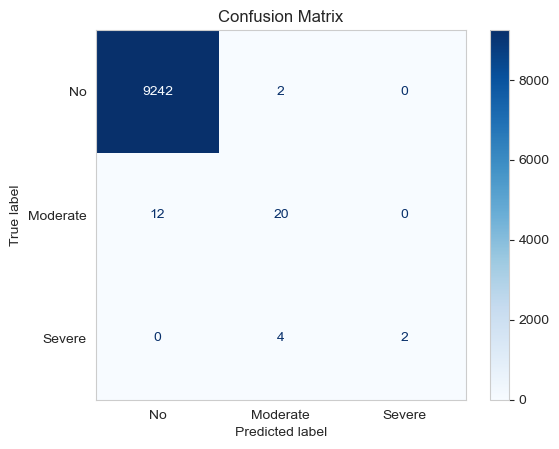

In [672]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Your existing code up to predictions
y_pred_encoded = xgb_model.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

order = ['No', 'Moderate', 'Severe']

cm = confusion_matrix(y_test, y_pred, labels=order)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=order)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()